In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
Microsoft = data.DataReader("MSFT", data_source="yahoo", start = "1986-03-01", end = "2019-06-01")
Microsoft.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1986-03-13,0.101562,0.088542,0.088542,0.097222,1.031789e+09,0.069996
1986-03-14,0.102431,0.097222,0.097222,0.100694,3.081600e+08,0.072496
1986-03-17,0.103299,0.100694,0.100694,0.102431,1.331712e+08,0.073746
1986-03-18,0.103299,0.098958,0.102431,0.099826,6.776640e+07,0.071871
1986-03-19,0.100694,0.097222,0.099826,0.098090,4.789440e+07,0.070621


In [3]:
Microsoft.shape

(8369, 6)

In [4]:
Microsoft_train = Microsoft.iloc[:8100, :]
Microsoft_train.shape

(8100, 6)

In [5]:
Microsoft_test = Microsoft.iloc[8100:, :]
Microsoft_test.shape

(269, 6)

In [6]:
training_set = Microsoft.iloc[:8100, 2:3].values
training_set

array([[8.85416642e-02],
       [9.72222239e-02],
       [1.00694448e-01],
       ...,
       [9.35500031e+01],
       [9.75999985e+01],
       [9.63300018e+01]])

In [7]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 8099):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
8039/8039 [==============================] - 89s 11ms/step - loss: 0.0037
Epoch 2/50
8039/8039 [==============================] - 79s 10ms/step - loss: 0.0012
Epoch 3/50
8039/8039 [==============================] - 75s 9ms/step - loss: 8.6770e-04
Epoch 4/50
8039/8039 [==============================] - 73s 9ms/step - loss: 8.9566e-04
Epoch 5/50
8039/8039 [==============================] - 73s 9ms/step - loss: 7.9029e-04
Epoch 6/50
8039/8039 [==============================] - 78s 10ms/step - loss: 7.5759e-04
Epoch 7/50
8039/8039 [==============================] - 79s 10ms/step - loss: 6.2262e-04
Epoch 8/50
8039/8039 [==============================] - 77s 10ms/step - loss: 6.7337e-04
Epoch 9/50
8039/8039 [==============================] - 77s 10ms

In [9]:
# Part 3 - Making the predictions and visualising the results

# Getting the real recent stock price until May 2019
real_stock_price = Microsoft_test.iloc[:, 2:3].values

In [10]:
# Getting the predicted stock price until May 2019
Microsoft_total = pd.concat((Microsoft_train['Close'], Microsoft_test['Close']), axis = 0)
inputs = Microsoft_total[len(Microsoft_total) - len(Microsoft_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 329):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

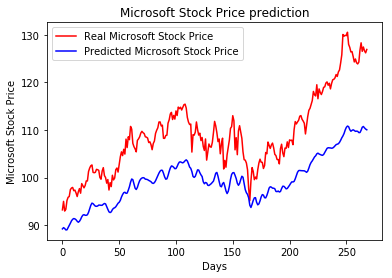

In [11]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Microsoft Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Microsoft Stock Price')
plt.title('Microsoft Stock Price prediction')
plt.xlabel('Days')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.show()

In [12]:
#Evaluating the RNN
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

10.150324969847377

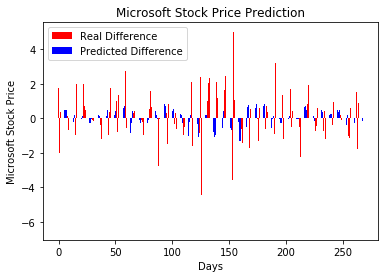

In [13]:
# Visualising the results
 
shift_pred= predicted_stock_price[:-1]
shift_pred = np.append(0, np.reshape(shift_pred, len(shift_pred)))
shift_real = real_stock_price[:-1]
shift_real = np.append(0, np.reshape(shift_real, len(shift_real)))
 
dif_pred = np.add(np.reshape(predicted_stock_price, len(predicted_stock_price)), - shift_pred)[1:]
dif_real = np.add(np.reshape(real_stock_price, len(real_stock_price)), - shift_real)[1:]
 
fig, ax = plt.subplots()
ind = np.arange(dif_real.size)
real_bar = ax.bar(ind-0.15, dif_real, width=0.3, color = 'red', label = 'Real Difference')
pred_bar = ax.bar(ind+0.15, dif_pred, width=0.3, color = 'blue', label = 'Predicted Difference')
ax.set_title('Microsoft Stock Price Prediction')
ax.set_xlabel('Days')
ax.set_ylabel('Microsoft Stock Price')
ax.legend()
plt.show()